In [153]:
import os
import re
import unicodedata
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModel
from pythainlp.tokenize import word_tokenize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce  

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import networkx as nx

part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp


Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}

In [154]:
# =========================
# Load & clean data
# =========================
df = pd.read_csv('news_dataset_truefakenews.csv')
df = df.rename(columns={'lable': 'label', 'autor': 'author'})


In [155]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'คลังความรู้': 'true',
    'ข่าวปลอม': 'fake',
    'อาชญากรออนไลน์': 'fake',
    'ข่าวบิดเบือน': 'fake',
    'ข่าวอื่นๆ': None  # ลบออกเลย
}

In [156]:
# ทำความสะอาด label ลบอิโมจิ และแมปค่า 
# Normalization Function
ZW = ''.join(['\u200B', '\u200C', '\u200D', '\uFEFF'])
def normalize_thai(s):
    if pd.isna(s):
        return None
    s = str(s).replace('\u00A0', ' ').translate({ord(ch): None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # collapse repeated diacritics/marks
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['label'] = df['label'].apply(normalize_thai)

# canonical labels and aliases -> map to two classes
CANON = {'ข่าวจริง': 'ข่าวจริง', 'ข่าวปลอม': 'ข่าวปลอม'}
ALIASES = {'ข่าวจริิง': 'ข่าวจริง', 'ข่่าวจริง': 'ข่าวจริง', 'ข่่าวบิดเบือน': 'ข่าวปลอม'}
df['label'] = df['label'].replace(ALIASES)
df = df[df['label'].isin(CANON.keys())].dropna(subset=['title', 'content']).reset_index(drop=True)




In [157]:
# สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
#df['label_binary'] = df['label'].map(label_map)

# ลบแถวที่เป็น None (ข่าวอื่นๆ)
#df = df.dropna(subset=['label_binary'])

# ถ้าต้องการ save เป็น CSV ใหม่
#df.to_csv('news_dataset_truefakenews.csv', index=False)

# ดูผลลัพธ์
print(df.head())

                  date                                         link  \
0  23/07/2568 09:00:20  https://www.antifakenewscenter.com/?p=74581   
1  23/07/2568 08:00:51  https://www.antifakenewscenter.com/?p=74577   
2  23/07/2568 07:00:51  https://www.antifakenewscenter.com/?p=74573   
3  23/07/2568 06:30:23  https://www.antifakenewscenter.com/?p=74569   
4  23/07/2568 03:30:03  https://www.antifakenewscenter.com/?p=74561   

                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยส

In [158]:
#  ตัดคำ (ไม่เก็บช่องว่าง)
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)

In [159]:
# โหลดโมเดลภาษาไทย + จัด device
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
lm_model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lm_model = lm_model.to(device).eval()


In [160]:
# Fixed mapping so indices stay consistent
label2id = {'ข่าวจริง': 0, 'ข่าวปลอม': 1}
id2label = {v: k for k, v in label2id.items()}

Dataset Size: 818 | ข่าวจริง: 233, ข่าวปลอม: 585


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

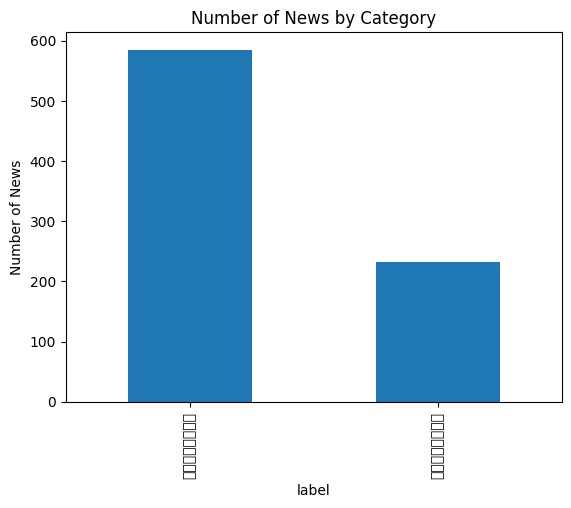

Token statistics:
Average tokens in titles: 12.15
Average tokens in content: 110.50


In [161]:
num_true = (df['label'] == 'ข่าวจริง').sum()
num_fake = (df['label'] == 'ข่าวปลอม').sum()
print(f"Dataset Size: {len(df)} | ข่าวจริง: {num_true}, ข่าวปลอม: {num_fake}")

# optional quick bar plot
try:
    df['label'].value_counts().plot(kind='bar')
    plt.title('Number of News by Category')
    plt.ylabel('Number of News')
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

# optional Thai tokenization stats (not used in BERT input)
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)
print("Token statistics:")
print(f"Average tokens in titles: {df['title_tokens'].str.len().mean():.2f}")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

In [162]:
# ดูตัวอย่าง tokenized titles and content
print("Sample of tokenized titles:")
print(df[['title', 'title_tokens']].head())
print("\nSample of tokenized content:")
print(df[['content', 'content_tokens']].head())

# Print token statistics
print("\nToken statistics:")
print(f"Average tokens in titles: {df['title_tokens'].str.len().mean():.2f}")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

Sample of tokenized titles:
                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                        title_tokens  
0  [OR, ชวน, ร่วม, เป็น, เจ้าของกิจการ, ลงทุน, หุ...  
1  [กระทรวงยุติธรรม, เปิด, เพจ, เฟซบุ๊ก, ชื่อ, Te...  
2  [หุ้น, OKJ, เปิด, เทรด, วัน, แรก, ราคา, เปิด, ...  
3  [กรุงไทย, เปิด, ให้, จอง, สิทธิ์, ยืม, เงิน, 1...  
4  [ก.ล.ต., เปิด, เว็บไซต์, ให้, ผู้ลงทุน, สะสม, ...  

Sample of tokenized content:
                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยสินเชื่อ บนบัญชี TikTok ชื่อ ktb.thai ..

In [163]:
# -------------------------------------------
#  ฟังก์ชันสร้าง BERT Embedding WangchanBERT 
# -------------------------------------------
@torch.no_grad()
def get_bert_embedding_from_text(text, max_length=256, use_mean_pool=True):
    """
    Return numpy vector for text using mean-pool of token vectors (mask-aware).
    """
    if pd.isna(text):
        text = ""
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    ).to(device)
    outputs = lm_model(**inputs)
    if use_mean_pool:
        attn = inputs['attention_mask'].unsqueeze(-1)  # (1, L, 1)
        summed = (outputs.last_hidden_state * attn).sum(dim=1)  # (1, hidden)
        denom = attn.sum(dim=1).clamp(min=1)
        emb = (summed / denom).squeeze(0).cpu().numpy()
    else:
        emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()  # CLS
    return emb

In [164]:
print("\nCreating BERT Embeddings for Title and Content...")
title_emb = np.vstack([get_bert_embedding_from_text(text, use_mean_pool=True) for text in df['title']])
content_emb = np.vstack([get_bert_embedding_from_text(text, use_mean_pool=True) for text in df['content']])

print(f"Title embeddings shape: {title_emb.shape}")
print(f"Content embeddings shape: {content_emb.shape}")

# concatenate (title + content) and normalize each row (L2)
x_np = np.hstack([title_emb, content_emb])  # shape (N, 1536) if each is 768
x_np = normalize(x_np, axis=1, norm='l2')
y_np = df['label'].map(label2id).values

print(pd.DataFrame(x_np).head())
print("x_np shape:", x_np.shape)
print("Example vector (first 10 dims):", x_np[0][:10], "...")



Creating BERT Embeddings for Title and Content...


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Title embeddings shape: (818, 768)
Content embeddings shape: (818, 768)
       0         1         2         3         4         5         6     \
0  0.009440 -0.055937  0.010781  0.009715 -0.020595 -0.016658  0.038007   
1 -0.018866 -0.013389  0.029290  0.028072 -0.023694  0.024845 -0.002467   
2 -0.004297 -0.054674  0.006164  0.025670 -0.008726 -0.025533  0.022739   
3 -0.004038 -0.037407  0.017466  0.014555 -0.016643  0.004019  0.036810   
4  0.050563  0.012704 -0.000594  0.020924  0.015106  0.027066  0.027630   

       7         8         9     ...      1526      1527      1528      1529  \
0 -0.002626 -0.004493  0.001407  ... -0.011996  0.003064  0.017463  0.001360   
1 -0.008415  0.002117 -0.026758  ...  0.012361  0.004698  0.013069  0.012872   
2 -0.017483 -0.005550  0.017755  ...  0.000092 -0.000812  0.001738  0.010710   
3 -0.022862 -0.012967  0.014511  ...  0.004602  0.002643  0.001115  0.022412   
4  0.013650  0.021515  0.013401  ... -0.005073  0.000831  0.013191 -0.001225 

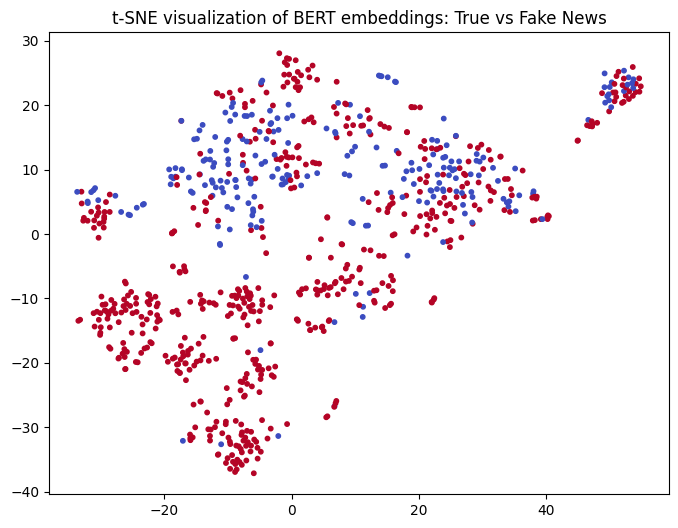

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

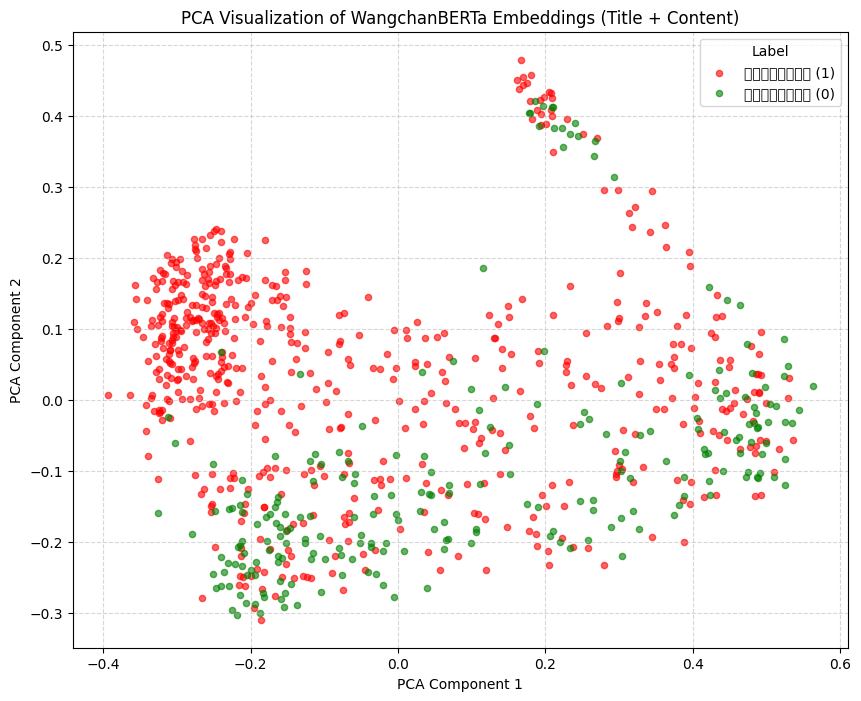

Unique labels: ['ข่าวปลอม' 'ข่าวจริง']


In [165]:
# =========================
# Visualization 
# =========================
try:
    tsne = TSNE(n_components=2, random_state=SEED, init='pca', learning_rate='auto')
    x_2d_tsne = tsne.fit_transform(x_np)
    plt.figure(figsize=(8,6))
    plt.scatter(x_2d_tsne[:,0], x_2d_tsne[:,1], c=y_np, cmap='coolwarm', s=10)
    plt.title("t-SNE visualization of BERT embeddings: True vs Fake News")
    plt.show()
except Exception as e:
    print("t-SNE skipped:", e)

try:
    pca = PCA(n_components=2, random_state=SEED)
    x_2d_pca = pca.fit_transform(x_np)
    fake_mask = (y_np == label2id['ข่าวปลอม'])
    real_mask = (y_np == label2id['ข่าวจริง'])
    plt.figure(figsize=(10,8))
    plt.scatter(x_2d_pca[fake_mask,0], x_2d_pca[fake_mask,1], color='red', alpha=0.6, s=20, label='ข่าวปลอม (1)')
    plt.scatter(x_2d_pca[real_mask,0], x_2d_pca[real_mask,1], color='green', alpha=0.6, s=20, label='ข่าวจริง (0)')
    plt.title("PCA Visualization of WangchanBERTa Embeddings (Title + Content)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Label")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print("PCA plot skipped:", e)

print("Unique labels:", df['label'].unique())

หน้าตาเป็นไง ใช้สูตรอะไร

In [166]:
# ดูตัวอย่าง DataFrame ของ Embedding
import pandas as pd
pd.DataFrame(x_np).head()

print(x_np.shape)   # ดูขนาด เช่น (จำนวนเอกสาร, ขนาดเวกเตอร์)
print(x_np[0])      # ดู embedding ของตัวอย่างแรก


(818, 1536)
[ 0.00943962 -0.05593715  0.01078102 ... -0.00691378  0.03518404
  0.01866273]


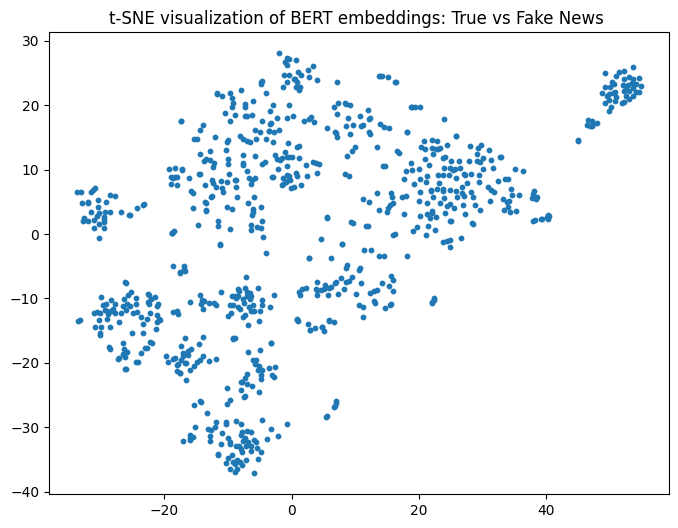

In [167]:
#ดูกราฟt-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#ด้านความหมาย

tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_np)

plt.figure(figsize=(8,6))
plt.scatter(x_2d[:,0], x_2d[:,1], s=10)
plt.title("t-SNE visualization of BERT embeddings: True vs Fake News ")
plt.show()


เสร็จ embedding //ทำไมจุดเป็นแบบนี้

In [168]:
# ---  การสร้าง kNN-Graph และ Data Object ---

# แปลง labels -> ตัวเลข
classes = sorted(df['label'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['label'].map(label2id).values
print(f"Classes: {label2id}")

Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

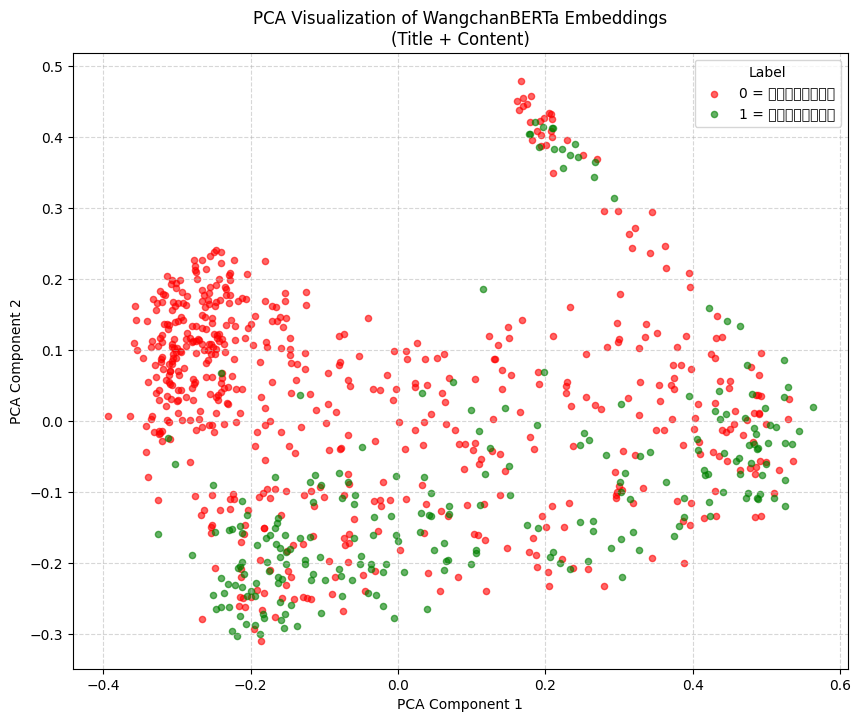

In [169]:
# สร้าง kNN Graph (0=ข่าวจริง, 1=ข่าวปลอม)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


labels_numeric = y_np # y_np คือ Label ที่ถูก map เป็น 0, 1 แล้ว (0=ข่าวจริง, 1=ข่าวปลอม)
id2label = {i: c for c,i in label2id.items()} # เพื่อให้รู้ว่า 0 คืออะไร 1 คืออะไร

# ทำ PCA เหมือนเดิม
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_np)

# แยกจุดตาม class (โดยใช้ตัวเลข)
fake_mask = labels_numeric == 1
fact_mask = labels_numeric == 0

# พล็อต scatter พร้อมสี
plt.figure(figsize=(10, 8))

# พล็อต 'ข่าวปลอม' (Label 1)
plt.scatter(x_2d[fake_mask, 0], x_2d[fake_mask, 1], 
            color='red', alpha=0.6, s=20, 
            label=f'0 = {id2label.get(0, "N/A")}')

# พล็อต 'ข่าวจริง' (Label 0)
plt.scatter(x_2d[fact_mask, 0], x_2d[fact_mask, 1], 
            color='green', alpha=0.6, s=20, 
            label=f'1 = {id2label.get(1, "N/A")}')

plt.title("PCA Visualization of WangchanBERTa Embeddings\n(Title + Content)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Label")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [170]:
print(df['label'].unique())


['ข่าวปลอม' 'ข่าวจริง']


Building kNN Graph with k=8...


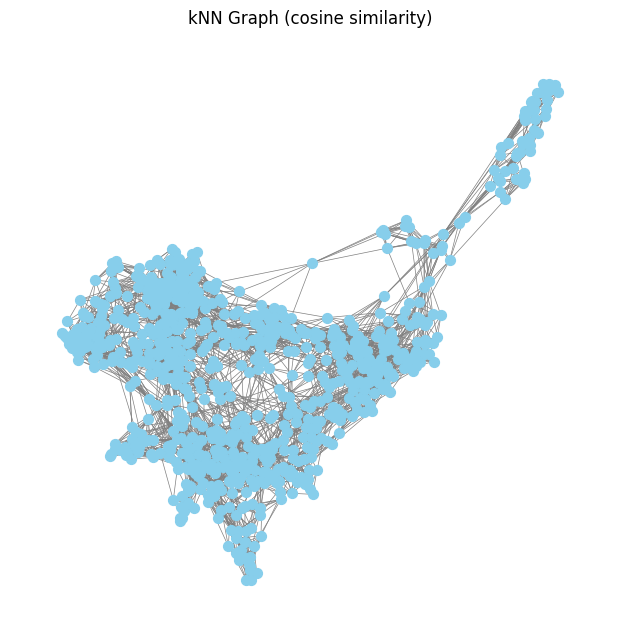

In [171]:
N = x_np.shape[0]
k = 8  # fixed k used in training and prediction
print(f"Building kNN Graph with k={k}...")

nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(x_np)
dist, idx = nbrs.kneighbors(x_np)  # dist shape (N, k+1), idx shape (N, k+1)

src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1)  # similarity scores

edge_index_np = np.vstack([src, dst])  # (2, E)
# make undirected by adding reverse edges
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# coalesce to remove duplicates and aggregate weights
try:
    edge_index, edge_weight = coalesce(edge_index, edge_weight, N, reduce='mean')
except TypeError:
    # older/newer signature: try without explicit reduce or different order
    try:
        edge_index, edge_weight = coalesce(edge_index, edge_weight, num_nodes=N)
    except Exception as e:
        print("Warning: coalesce failed, proceeding without coalesce:", e)

# optional quick graph visualize
try:
    G = nx.Graph()
    edges = list(zip(edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()))
    G.add_edges_from(edges)
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=SEED)
    nx.draw(G, pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=50, width=0.5)
    plt.title("kNN Graph (cosine similarity)")
    plt.show()
except Exception as e:
    print("Graph plot skipped:", e)

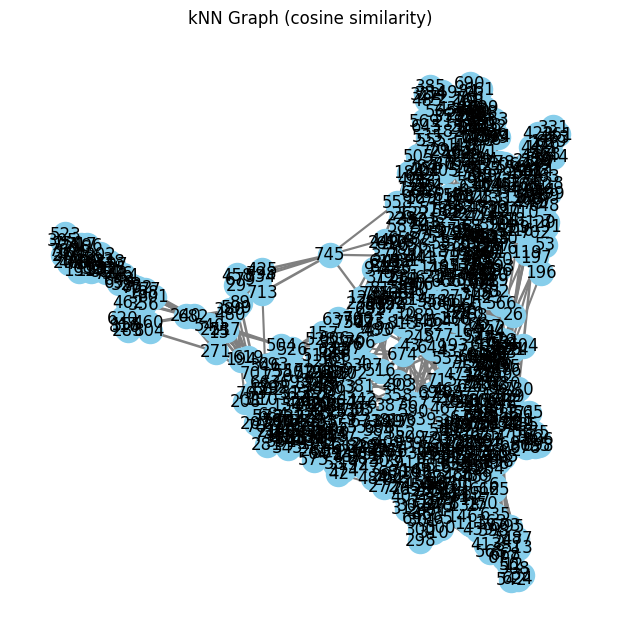

In [172]:
# พล็อตกราฟ kNN
import networkx as nx
import matplotlib.pyplot as plt

# สร้างกราฟจาก edge_index_np
G = nx.Graph()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# ถ้าอยากใช้ weight เป็นความหนาของเส้น
weights = edge_weight_np

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout สวยงามอัตโนมัติ
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights * 2)
plt.title("kNN Graph (cosine similarity)")
plt.show()


In [173]:
# =========================
# Create PyG Data and splits
# =========================
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
data.edge_weight = edge_weight

# split 70/15/15 (train/val/test)
idx_all = np.arange(N)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_np, random_state=SEED)
# from remaining, take validation ~15% of total -> of remaining size, val fraction = 0.1765 approx
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_np[idx_train], random_state=SEED)

train_mask = torch.zeros(N, dtype=torch.bool)
train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool)
val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool)
test_mask[idx_test] = True

data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

print("Label distribution (y_np):", np.unique(y_np, return_counts=True))
print(f"Train size: {train_mask.sum().item()}, Val size: {val_mask.sum().item()}, Test size: {test_mask.sum().item()}")

Label distribution (y_np): (array([0, 1]), array([233, 585]))
Train size: 572, Val size: 123, Test size: 123


In [174]:
# ตรวจสอบ label distribution
print(y_np)  # แสดงค่าทุกอัน
print(np.unique(y_np, return_counts=True))  

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 

In [175]:
# =========================
# GCN Model
# =========================
class GCNNet(nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=256, dropout_rate=0.4):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, getattr(data, 'edge_weight', None)
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x  # raw logits

def evaluate_masked(logits, mask, data):
    y_true = data.y[mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, f1m
# =========================
# Training Setup
# =========================
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(label2id)
LR_RATE = 1e-3
WEIGHT_DECAY = 5e-4
PATIENCE_LIMIT = 30
SCHEDULER_PATIENCE = 15

model_gnn = GCNNet(num_node_features=NUM_NODE_FEATURES, num_classes=NUM_CLASSES).to(device)
data = data.to(device)

# class weights computed from train set only (inverse frequency, normalized)
cls_count = np.bincount(y_np[idx_train], minlength=NUM_CLASSES).astype(np.float32)
cls_w = torch.tensor((cls_count.sum() / (cls_count + 1e-9)), dtype=torch.float, device=device)
cls_w = cls_w / cls_w.mean()

opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE)

In [176]:
# ===== Training loop =====
num_epochs = 500
best_val_f1, best_state, best_epoch = -1.0, None, 0
patience_counter = 0

print("\n--- Starting GCN Training ---")
for epoch in range(1, num_epochs + 1):
    model_gnn.train()
    opt.zero_grad()
    out = model_gnn(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    loss.backward()
    opt.step()

    model_gnn.eval()
    with torch.no_grad():
        val_acc, val_f1 = evaluate_masked(out, data.val_mask, data)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model_gnn.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    scheduler.step(val_f1)

    if epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val F1: {val_f1:.4f} | LR: {opt.param_groups[0]['lr']:.1e} | Patience: {patience_counter}")

    if patience_counter >= PATIENCE_LIMIT:
        print(f"\nEarly stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} (epoch {best_epoch})")
        break



--- Starting GCN Training ---
Epoch 050 | Loss: 0.4051 | Val F1: 0.8373 | LR: 1.0e-03 | Patience: 13

Early stopping at epoch 67. Best F1: 0.8537 (epoch 37)


In [177]:
# load best state if available
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device) for k, v in best_state.items()})
else:
    print("Warning: best_state is None, using final model.")

In [178]:
# =========================
# Inductive prediction function (GCN + BERT embeddings)
# =========================
def predict_news(title=None, content=None, topn=None):
    assert title or content, "ต้องใส่อย่างน้อย title หรือ content"
    if topn is None:
        topn = k

    title_text = title if title else ""
    content_text = content if content else ""
    title_emb = get_bert_embedding_from_text(title_text, use_mean_pool=True)
    content_emb = get_bert_embedding_from_text(content_text, use_mean_pool=True)
    emb = np.concatenate([title_emb, content_emb], axis=0)
    emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')[0]

    # find k nearest neighbors from training corpus (x_np is global)
    nbrs_local = NearestNeighbors(n_neighbors=topn, metric='cosine').fit(x_np)
    dists, idxs = nbrs_local.kneighbors(emb.reshape(1, -1))
    idxs = idxs[0]
    X_new = np.vstack([emb, x_np[idxs]])

    # build star mini-graph: new node 0 connected to neighbors 1..topn
    edge_index_new = np.concatenate([
        np.stack([np.zeros(topn, dtype=int), np.arange(1, topn+1)]),
        np.stack([np.arange(1, topn+1), np.zeros(topn, dtype=int)])
    ], axis=1)
    edge_weight_new = np.concatenate([1 - dists[0], 1 - dists[0]])

    x_tensor = torch.tensor(X_new, dtype=torch.float, device=device)
    edge_index_tensor = torch.tensor(edge_index_new, dtype=torch.long, device=device)
    edge_weight_tensor = torch.tensor(edge_weight_new, dtype=torch.float, device=device)
    data_new = Data(x=x_tensor, edge_index=edge_index_tensor, edge_weight=edge_weight_tensor)

    model_gnn.eval()
    with torch.no_grad():
        logits = model_gnn(data_new)
        probas = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_id = int(logits[0].argmax(dim=-1).item())
        label_pred = id2label[pred_id]
    return {'label': label_pred, 'probability': float(probas[pred_id]), 'proba_all': probas, 'id2label': id2label}


In [179]:
# =========================
# Evaluate GCN on Test set
# =========================
model_gnn.eval()
with torch.no_grad():
    final_out_gcn = model_gnn(data)
    test_acc_gcn, test_f1_gcn = evaluate_masked(final_out_gcn, data.test_mask, data)
    y_true_gcn = data.y[data.test_mask].cpu().numpy()
    y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()
    f1_class_gcn = f1_score(y_true_gcn, y_pred_gcn, average=None, zero_division=0)

results_gcn = {
    'Accuracy': test_acc_gcn,
    'F1-Macro': test_f1_gcn,
    'F1 (ข่าวจริง)': f1_class_gcn[label2id['ข่าวจริง']] if len(f1_class_gcn) > 0 else 0,
    'F1 (ข่าวปลอม)': f1_class_gcn[label2id['ข่าวปลอม']] if len(f1_class_gcn) > 1 else 0
}
print("-" * 50)
print(f"Training Complete. Best val F1: {best_val_f1:.4f} at epoch {best_epoch}")
print(f"Test (GCN): Accuracy: {test_acc_gcn:.4f}, F1-Macro: {test_f1_gcn:.4f}")
print("Per-class F1 (GCN):", results_gcn)


--------------------------------------------------
Training Complete. Best val F1: 0.8537 at epoch 37
Test (GCN): Accuracy: 0.7480, F1-Macro: 0.7271
Per-class F1 (GCN): {'Accuracy': 0.7479674796747967, 'F1-Macro': 0.727116581979532, 'F1 (ข่าวจริง)': np.float64(0.651685393258427), 'F1 (ข่าวปลอม)': np.float64(0.802547770700637)}


In [180]:
# --- ตัวอย่างการใช้งานจริง ---

print("\n--- DEMO: Test Inductive Prediction ---")
# ข่าวจริงตัวอย่าง
title_real = "นายกรัฐมนตรีประกาศเพิ่มค่าแรงขั้นต่ำทั่วประเทศ เริ่มต้นปีหน้า"
content_real = "กระทรวงแรงงานยืนยันว่าการปรับขึ้นค่าแรงขั้นต่ำมีผลบังคับใช้ตั้งแต่วันที่ 1 มกราคม 2569 ตามมติคณะรัฐมนตรี เพื่อยกระดับความเป็นอยู่ของแรงงาน"

# ข่าวปลอมตัวอย่าง (สมมติ)
title_fake = "ด่วน! รัฐบาลออกกฎหมายบังคับให้ประชาชนทุกคนต้องฉีดวัคซีนป้องกันหวัดสายพันธุ์ใหม่"
content_fake = "ข่าวลือที่แพร่หลายในโซเชียลมีเดียระบุว่า หากไม่ฉีดวัคซีนตามที่รัฐบาลกำหนด จะถูกปรับเป็นเงิน 100,000 บาท ซึ่งหน่วยงานสาธารณสุขได้ออกมาปฏิเสธและชี้แจงแล้ว"

# ทายข่าวปลอม
result_fake = predict_news(title=title_fake, content=content_fake)
print(f"\n[ข่าวปลอมตัวอย่าง]\nทำนาย: {result_fake['label']} | ความมั่นใจ: {result_fake['probability']:.3f}")
print(f"Probas: {result_fake['id2label'][0]}: {result_fake['proba_all'][0]:.3f}, {result_fake['id2label'][1]}: {result_fake['proba_all'][1]:.3f}")

# ทายข่าวจริง
result_real = predict_news(title=title_real, content=content_real)
print(f"\n[ข่าวจริงตัวอย่าง]\nทำนาย: {result_real['label']} | ความมั่นใจ: {result_real['probability']:.3f}")
print(f"Probas: {result_real['id2label'][0]}: {result_real['proba_all'][0]:.3f}, {result_real['id2label'][1]}: {result_real['proba_all'][1]:.3f}")


--- DEMO: Test Inductive Prediction ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[ข่าวปลอมตัวอย่าง]
ทำนาย: ข่าวจริง | ความมั่นใจ: 0.594
Probas: ข่าวจริง: 0.594, ข่าวปลอม: 0.406


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



[ข่าวจริงตัวอย่าง]
ทำนาย: ข่าวจริง | ความมั่นใจ: 0.839
Probas: ข่าวจริง: 0.839, ข่าวปลอม: 0.161


In [183]:
import numpy as np
from sklearn.metrics import classification_report

# 📌 1. กำหนดค่า 'k' (topn) หากยังไม่ได้กำหนดไว้เป็น Global Variable
# ค่านี้คือจำนวนเพื่อนบ้านที่ใช้สร้าง mini-graph
try:
    k 
except NameError:
    k = 5 
    print(f"Set default k = {k} for topn.")

# 📌 2. สร้างชุดข้อมูลทดสอบใหม่ (Test Set) 20 ข่าว
# 'label_true': 0 = ข่าวจริง, 1 = ข่าวปลอม (ตาม label2id: {'ข่าวจริง': 0, 'ข่าวปลอม': 1})
test_news_data = [
    # --- ข่าวจริง 10 ตัวอย่าง (Label 0) ---
    {"title": "ททท. เปิดตัว “ลิซ่า” เป็นตัวแทนการท่องเที่ยวไทย Amazing Thailand Ambassador", "content": "การท่องเที่ยวแห่งประเทศไทย (ททท.) ยืนยันการแต่งตั้ง 'ลิซ่า Blackpink' เป็นทูตการท่องเที่ยวเพื่อดึงดูดนักท่องเที่ยวต่างชาติ", "label_true": 0},
    {"title": "สั่งสำรวจ-เก็บวัตถุโบราณ เร่งบูรณะ 'พระธาตุโนนตาล' หลังพังถล่มจากฝนตกหนัก", "content": "กรมศิลปากรและหน่วยงานท้องถิ่นเข้าตรวจสอบและเริ่มกระบวนการซ่อมแซมองค์พระธาตุที่ได้รับความเสียหายจากพายุฝน", "label_true": 0},
    {"title": "บขส. เปิดให้บริการเดินรถโดยสาร เส้นทาง ขอนแก่น – นครหลวงเวียงจันทน์", "content": "บริษัท ขนส่ง จำกัด (บขส.) ประกาศกลับมาเปิดเดินรถระหว่างประเทศสายขอนแก่น-เวียงจันทน์แล้ว", "label_true": 0},
    {"title": "อุทยานฯ เขาพนมเบญจา ชวนนักท่องเที่ยว ตามรอยจูราสสิค เวิลด์ กำเนิดชีวิตใหม่ น้ำตกห้วยโต้", "content": "อุทยานแห่งชาติเขาพนมเบญจา จ.กระบี่ เปิดเส้นทางศึกษาธรรมชาติใหม่และเชิญชวนท่องเที่ยวในช่วงฤดูหนาว", "label_true": 0},
    {"title": "พบอิฐโบราณชิ้นสำคัญ หลักฐานทางประวัติศาสตร์ที่เก่าแก่ของเชียงราย", "content": "กรมศิลปากรยืนยันการค้นพบชิ้นส่วนอิฐสมัยโบราณในพื้นที่ อ.เชียงแสน ซึ่งเป็นหลักฐานสำคัญของอาณาจักรล้านนา", "label_true": 0},
    {"title": "ปิดเทอม สวนสัตว์เปิดเขาเขียว เผยโฉม 'ลูกสมเสร็จตัวล่าสุด' เด็กเที่ยวฟรี 23 ตุลาคมนี้", "content": "สวนสัตว์เปิดเขาเขียวเชิญชวนนักท่องเที่ยวชมลูกสมเสร็จเกิดใหม่ และมีโปรโมชั่นเข้าชมฟรีสำหรับเด็กในวันปิยมหาราช", "label_true": 0},
    {"title": "อาการเจ็บหน้าอก สัญญาณอันตรายที่ไม่ควรมองข้าม", "content": "สถาบันโรคหัวใจแนะนำให้ประชาชนรีบพบแพทย์ทันทีหากมีอาการเจ็บแน่นหน้าอกที่อาจเป็นสัญญาณของกล้ามเนื้อหัวใจขาดเลือด", "label_true": 0},
    {"title": "กกล.บูรพา จับกุมแรงงานกัมพูชา 11 คน ลักลอบข้ามชายแดนสระแก้ว", "content": "กองกำลังบูรพาแถลงการณ์จับกุมแรงงานต่างด้าวผิดกฎหมายตามแนวชายแดนได้จำนวนหนึ่งเพื่อป้องกันการแพร่ระบาด", "label_true": 0},
    {"title": "ททท.คาด 'เทศกาลกินผักภูเก็ต 2568' คึกคัก รายได้ทะลุ 22,000 ล้านบาท หนุนเศรษฐกิจสะพัด", "content": "การท่องเที่ยวแห่งประเทศไทยคาดการณ์ว่าเทศกาลกินเจที่ภูเก็ตในปีนี้จะมีมูลค่าทางเศรษฐกิจสูงกว่าปีที่ผ่านมา", "label_true": 0},
    {"title": "“ข้าวต้ม” ฟื้นตัวดี ถีบตัวลุกได้ ทีมแพทย์ช่วยกายภาพต่อเนื่อง", "content": "รายงานอาการล่าสุดของลูกช้างป่า 'ข้าวต้ม' พบว่าอาการบาดเจ็บดีขึ้นมาก สามารถพยุงตัวลุกยืนได้แล้ว และยังคงทำกายภาพบำบัด", "label_true": 0},
    
    # --- ข่าวปลอม 10 ตัวอย่าง (Label 1) ---
    {"title": "ด่วน! สะพานกรุงเทพถล่ม มีผู้เสียชีวิต 36 ราย", "content": "มีรายงานข่าวลือทางโซเชียลมีเดียว่าสะพานกรุงเทพได้ถล่มลงมาเมื่อช่วงเช้าที่ผ่านมา ทำให้มีผู้บาดเจ็บและเสียชีวิตจำนวนมาก ซึ่งหน่วยงานรัฐยืนยันว่าเป็นข่าวปลอม", "label_true": 1},
    {"title": "กระทรวงยุติธรรม ร่วมกับ ตำรวจไซเบอร์ เปิดให้ลงทะเบียนยื่นหลักฐาน เพื่อรับเงินคืนจากมิจฉาชีพ", "content": "เพจเฟซบุ๊กปลอมเปิดรับลงทะเบียนเพื่อขอเงินคืนจากแก๊งคอลเซ็นเตอร์ โดยเรียกเก็บค่าธรรมเนียมก่อน ซึ่งถูกยืนยันแล้วว่าเป็นกลโกง", "label_true": 1},
    {"title": "การดื่มน้ำมะนาวสามารถทำลายมะเร็งเนื้อร้ายที่รุนแรงได้", "content": "ข่าวสุขภาพที่อ้างว่าน้ำมะนาวมีคุณสมบัติในการรักษาโรคมะเร็งได้ดีกว่าเคมีบำบัดนั้นถูกยืนยันโดยสถาบันมะเร็งแห่งชาติว่าเป็นข้อมูลเท็จ", "label_true": 1},
    {"title": "ผู้สูงอายุ 60 ปีขึ้นไป รับเงินอุดหนุนพิเศษ 3,000 บาท ไม่ต้องลงทะเบียน", "content": "ข้อความที่แชร์ในไลน์ว่าผู้สูงอายุจะได้รับเงินพิเศษ 3,000 บาทโดยอัตโนมัตินั้นไม่เป็นความจริง และไม่มีโครงการดังกล่าว", "label_true": 1},
    {"title": "กรมการขนส่งเปิดทำใบขับขี่ออนไลน์ ผ่านเพจเฟซบุ๊ก Pages DTL Noline", "content": "เพจเฟซบุ๊กแอบอ้างชื่อกรมการขนส่งทางบกเพื่อหลอกรับทำใบขับขี่ออนไลน์ โดยมีการเรียกเก็บค่าใช้จ่ายในการดำเนินการ", "label_true": 1},
    {"title": "กินถั่วลิสงวันละ 1 กำมือ ช่วยรักษาอาการวัยทอง อารมณ์แปรปรวน", "content": "ข้อมูลสุขภาพที่อ้างถึงการรักษาอาการวัยทองด้วยถั่วลิสงเป็นข่าวที่ไม่มีหลักฐานทางวิทยาศาสตร์รองรับและถูกจัดเป็นข่าวปลอม", "label_true": 1},
    {"title": "กฟภ. เปิดช่องทางติดต่อด่วน ทางไลน์ไอดี 'pea9394'", "content": "มีการแอบอ้างเป็นเจ้าหน้าที่การไฟฟ้าส่วนภูมิภาค (กฟภ.) ผ่านไลน์ไอดีที่ไม่เป็นทางการเพื่อหลอกลวงเก็บค่าไฟฟ้า", "label_true": 1},
    {"title": "สินเชื่อด่วนออมสิน สมัครง่าย ไม่ต้องใช้เอกสาร ติดต่อได้ที่เพจ Ulises Elizabeth Love", "content": "ธนาคารออมสินยืนยันว่าไม่มีนโยบายให้สินเชื่อผ่านเพจเฟซบุ๊กที่ไม่เป็นทางการ และเตือนภัยมิจฉาชีพที่แอบอ้าง", "label_true": 1},
    {"title": "รองแม่ทัพภาคที่ 2 ถูกตำหนิ เหตุรับเงินบริจาควัด", "content": "ข่าวที่ถูกนำเสนอว่ารองแม่ทัพถูกตำหนิเรื่องการรับเงินบริจาควัดนั้น ถูกกองทัพภาคที่ 2 ชี้แจงแล้วว่าเป็นการบิดเบือนข้อมูล", "label_true": 1},
    {"title": "วางก้อนน้ำแข็งบนท้ายทอย ช่วยรักษาโรคทางเดินหายใจ โรคหลอดเลือดหัวใจ และอาการปวดเมื่อยตามร่างกาย", "content": "ข้อความสุขภาพทางเลือกที่แนะนำให้ใช้น้ำแข็งรักษาหลายโรค เป็นข้อมูลที่ไม่ถูกต้องทางการแพทย์", "label_true": 1}
]

# 📌 3. วนลูปและทดสอบ (Testing)
y_true = []
y_pred = []
print("-" * 50)
print(f"--- Running Prediction on {len(test_news_data)} New Samples (topn={k}) ---")
print("-" * 50)

# กำหนด id2label เพื่อใช้อ้างอิงผลลัพธ์
id2label = {i: c for c, i in label2id.items()}

for i, news in enumerate(test_news_data):
    # เรียกใช้ฟังก์ชัน predict_news ที่ถูกแก้ไขแล้ว
    result = predict_news(
        title=news['title'],
        content=news['content'],
        #tokenizer=tokenizer,
        model_name=model_name,
        x_np=x_np, 
        label2id=label2id, 
        device=device, 
        topn=k # ใช้ค่า k ที่เรากำหนดไว้
    )
    
    # ดึงค่าผลลัพธ์
    label_id_pred = [k for k, v in id2label.items() if v == result['label']][0]
    
    y_true.append(news['label_true'])
    y_pred.append(label_id_pred)
    
    # แสดงผลลัพธ์แต่ละข่าว
    status = "✅ CORRECT" if label_id_pred == news['label_true'] else "❌ MISTAKE"
    
    print(f"[{status}] True: {id2label[news['label_true']]} | Pred: {result['label']} (Prob: {result['probability']:.3f})")
    if i == 9:
        print("\n--- Start of Fake News Examples ---")

# 📌 4. แสดงผลสรุปโดยใช้ Classification Report
print("-" * 50)
print("\n📝 CLASSIFICATION REPORT (20 Samples)")
print("-" * 50)
print(classification_report(y_true, y_pred, target_names=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'], zero_division=0))

--------------------------------------------------
--- Running Prediction on 20 New Samples (topn=8) ---
--------------------------------------------------


TypeError: predict_news() got an unexpected keyword argument 'model_name'

In [184]:
# --------------------------------------------------------
# 📌 โค้ดนี้ต้องถูกรัน 'หลังจาก' คุณรันโค้ดทดสอบ 20 ข่าวแล้ว
# --------------------------------------------------------
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

# ตรวจสอบว่ามี y_true และ y_pred จากการทดสอบหรือไม่
try:
    if not y_true or not y_pred:
        raise ValueError("y_true และ y_pred ยังไม่มีข้อมูล (กรุณารันโค้ดทดสอบ 20 ข่าวใหม่ก่อน)")
except NameError:
    print("❌ ERROR: ตัวแปร y_true หรือ y_pred ไม่ถูกนิยาม กรุณารันโค้ดส่วนทดสอบข่าว 20 ข่าวใหม่ก่อน")
    # สิ้นสุดการทำงาน
except ValueError as e:
    print(f"❌ ERROR: {e}")
    # สิ้นสุดการทำงาน
else:
    # 1. คำนวณ Metric หลัก
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # 2. สร้าง Classification Report
    report = classification_report(y_true, y_pred, 
                                   target_names=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'], 
                                   output_dict=True, zero_division=0)
    
    # 3. จัดรูปแบบตารางสรุปหลัก
    summary_data = {
        'Metric': ['Accuracy', 'F1-Macro Avg', 'ข่าวจริง F1-Score', 'ข่าวปลอม F1-Score'],
        'Score': [acc, f1_macro, report['ข่าวจริง (ID 0)']['f1-score'], report['ข่าวปลอม (ID 1)']['f1-score']]
    }
    df_summary = pd.DataFrame(summary_data).set_index('Metric')
    
    # 4. จัดรูปแบบตารางสรุปรายคลาส
    df_class = pd.DataFrame({
        'Precision': [report['ข่าวจริง (ID 0)']['precision'], report['ข่าวปลอม (ID 1)']['precision']],
        'Recall': [report['ข่าวจริง (ID 0)']['recall'], report['ข่าวปลอม (ID 1)']['recall']],
        'F1-Score': [report['ข่าวจริง (ID 0)']['f1-score'], report['ข่าวปลอม (ID 1)']['f1-score']],
        'Support': [report['ข่าวจริง (ID 0)']['support'], report['ข่าวปลอม (ID 1)']['support']]
    }, index=['ข่าวจริง (ID 0)', 'ข่าวปลอม (ID 1)'])
    
    # 5. แสดงผลลัพธ์
    print("-" * 60)
    print("📊 สรุปประสิทธิภาพโมเดล GCN บนชุดทดสอบ 20 ข่าวใหม่")
    print("-" * 60)
    
    print("\n1. ผลลัพธ์รวม (Overall Performance):")
    display(df_summary.style.format({'Score': "{:.4f}"}))
    
    print("\n2. รายงานประสิทธิภาพรายคลาส (Per-Class Metrics):")
    display(df_class.style.format("{:.4f}"))
    
    print("-" * 60)
    print(f"✅ ความแม่นยำรวม (Accuracy): {acc:.4f} (ทำนายถูก {int(acc * len(y_true))} จาก 20 ข่าว)")
    print("-" * 60)

❌ ERROR: y_true และ y_pred ยังไม่มีข้อมูล (กรุณารันโค้ดทดสอบ 20 ข่าวใหม่ก่อน)


In [ ]:
# # ------------------- รับ input จากผู้ใช้ -------------------
# title = input("กรอกหัวข้อข่าว (ถ้าไม่มี ให้กด Enter):\n")
# content = input("กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน):\n")

# # เช็คว่า:
# if not title and not content:
#     print("กรุณาใส่ title หรือเนื้อหาข่าว อย่างน้อย 1 อย่าง")
# else:
#     result = predict_news(
#         title=title,
#         content=content,
#         tokenizer=tokenizer,
#         model_gnn=model_gnn,
#         x_np=x_np, 
#         label2id=label2id, 
#         device=device, 
#         topn=8
#     )
    
#     print("\nผลการตรวจสอบข่าว:")
#     print(f">>> ข่าวนี้น่าจะเป็น :  {result['label']}  (ความมั่นใจ = {result['probability']:.3f})")
#     print("รายละเอียด probability (แต่ละ class):จริง ซ้าย/ปลอม ขวา", result['proba_all'])

node_pos: 30, color_map: 30, G.nodes: 30


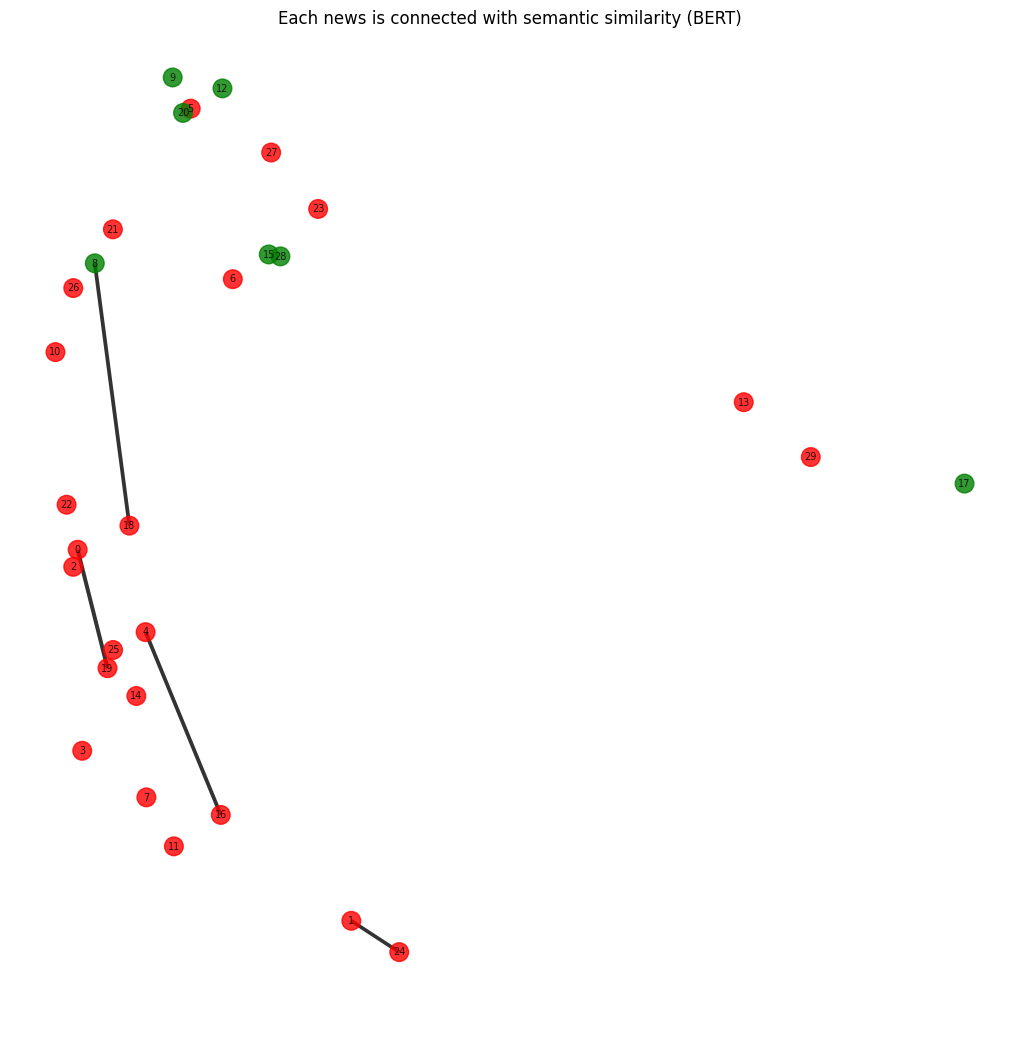

In [ ]:
#--- Visualize Subgraph ---
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# สมมติ plot 30 node แรก
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # เพื่อกัน node ที่ไม่มี edge หายไป
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='ข่าวปลอม' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

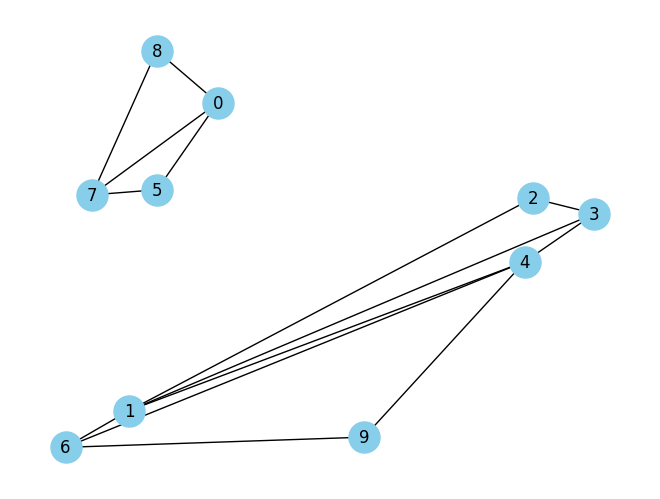

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN ง่ายๆ ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


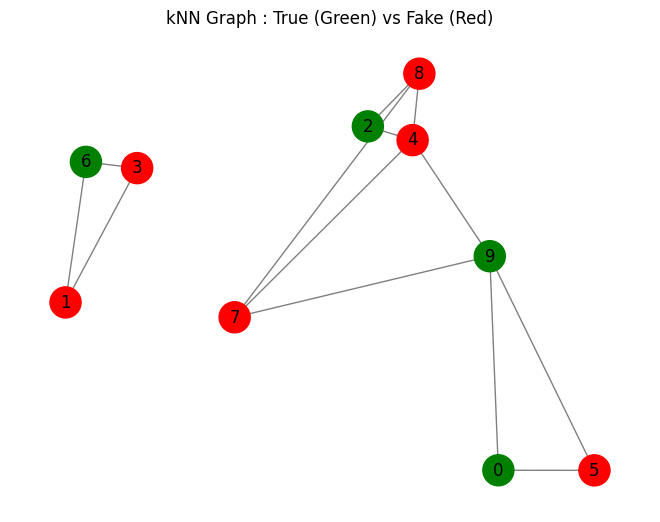

In [ ]:
#--- ตัวอย่างการสร้างกราฟ kNN พร้อมสีโหนดจาก label ---
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


In [ ]:
#--- ตัวอย่างการสร้าง GCN โมเดลง่ายๆ ---
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


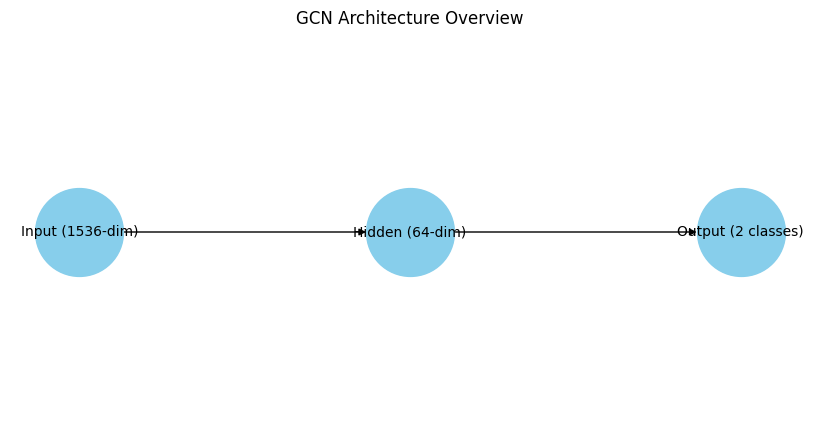

In [ ]:
# ----- วาดโครงสร้าง GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# เพิ่มโหนด
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# เพิ่ม edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# วาด
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


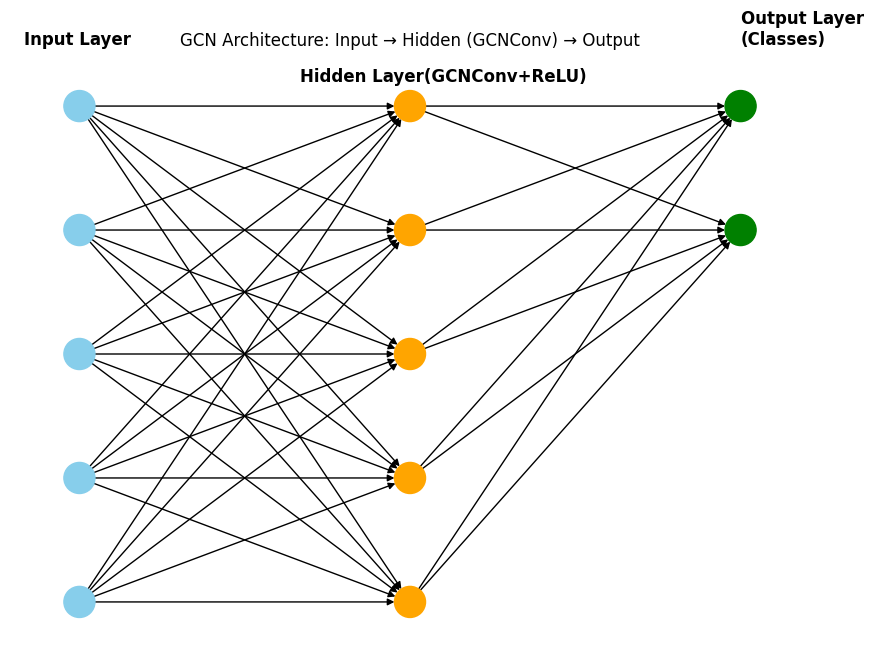

In [ ]:
#----- วาดโครงสร้าง GCN แบบละเอียด -----
import matplotlib.pyplot as plt
import networkx as nx

# สร้างโครงสร้าง GCN: Input Layer → Hidden Layer → Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ตัวอย่างมี 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# เพิ่ม node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# เชื่อม edge แบบ fully-connected ระหว่างแต่ละชั้น
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# จัดตำแหน่ง node แยกเป็น layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map สี
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# วาดกราฟ
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# เพิ่ม label ชื่อ layer (ใช้ตำแหน่งเฉพาะ)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input → Hidden (GCNConv) → Output")
plt.axis("off")
plt.show()



BERT MLP for compare

In [ ]:
# =========================
# BERT MLP Baseline
# =========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  # raw logits

In [ ]:
NUM_FEATURES = x_np.shape[1]
model_mlp = MLPClassifier(input_dim=NUM_FEATURES, hidden_dim=128, output_dim=NUM_CLASSES).to(device)

# prepare train/val/test for MLP using same splits
X_train, Y_train = x_np[idx_train], y_np[idx_train]
X_val, Y_val = x_np[idx_val], y_np[idx_val]
X_test, Y_test = x_np[idx_test], y_np[idx_test]

X_train_t = torch.tensor(X_train, dtype=torch.float, device=device)
Y_train_t = torch.tensor(Y_train, dtype=torch.long, device=device)
X_val_t = torch.tensor(X_val, dtype=torch.float, device=device)
Y_val_t = torch.tensor(Y_val, dtype=torch.long, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=device)
Y_test_t = torch.tensor(Y_test, dtype=torch.long, device=device)

# class weights from train only
cls_count_mlp = np.bincount(Y_train, minlength=NUM_CLASSES).astype(np.float32)
cls_w_mlp = (cls_count_mlp.sum() / (cls_count_mlp + 1e-9))
cls_w_mlp = cls_w_mlp / cls_w_mlp.mean()
cls_w_mlp = torch.tensor(cls_w_mlp, dtype=torch.float, device=device)

opt_mlp = torch.optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=5e-4)

print("\n--- Starting BERT Embedding Baseline Training (MLP) ---")
best_val_f1_mlp = -1.0
best_state_mlp = None
for epoch in range(1, 101):
    model_mlp.train()
    opt_mlp.zero_grad()
    out = model_mlp(X_train_t)
    loss = F.cross_entropy(out, Y_train_t, weight=cls_w_mlp)
    loss.backward()
    opt_mlp.step()

    model_mlp.eval()
    with torch.no_grad():
        val_logits = model_mlp(X_val_t)
        y_val_pred = val_logits.argmax(dim=1).cpu().numpy()
        f1_val = f1_score(Y_val, y_val_pred, average='macro', zero_division=0)

    if f1_val > best_val_f1_mlp:
        best_val_f1_mlp = f1_val
        best_state_mlp = {k: v.detach().cpu().clone() for k, v in model_mlp.state_dict().items()}

# load best mlp state
if best_state_mlp is not None:
    model_mlp.load_state_dict({k: v.to(device) for k, v in best_state_mlp.items()})


--- Starting BERT Embedding Baseline Training (MLP) ---


In [ ]:
# ----------------------------------------------------------------
# คำนวณและจัดเก็บ Metrics ของ MLP Baseline (Test Set)
# ----------------------------------------------------------------

def evaluate_simple(logits, y_true):
    y_pred = logits.argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    f1_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    return acc, f1m, f1_class

# evaluate on test
model_mlp.eval()
with torch.no_grad():
    out_test_mlp = model_mlp(X_test_t)
    y_pred_mlp = out_test_mlp.argmax(dim=1).cpu().numpy()
    test_acc_mlp = accuracy_score(Y_test, y_pred_mlp)
    test_f1_mlp = f1_score(Y_test, y_pred_mlp, average='macro', zero_division=0)
    f1_class_mlp = f1_score(Y_test, y_pred_mlp, average=None, zero_division=0)

results_mlp = {
    'Accuracy': test_acc_mlp,
    'F1-Macro': test_f1_mlp,
    'F1 (ข่าวจริง)': f1_class_mlp[label2id['ข่าวจริง']] if len(f1_class_mlp) > 0 else 0,
    'F1 (ข่าวปลอม)': f1_class_mlp[label2id['ข่าวปลอม']] if len(f1_class_mlp) > 1 else 0
}
print("\nBaseline MLP results:", results_mlp)
print(f"✅ MLP Baseline Test F1-Macro: {test_f1_mlp:.4f}")

✅ MLP Baseline Test F1-Macro: 0.8561


In [ ]:
# # ----------------------------------------------------------------
# #  Inductive Prediction Function (BERT ธรรมดา)
# # ----------------------------------------------------------------

# # แปลง label2id → inv_label_map
# inv_label_map = {v: k for k, v in label2id.items()}

# def predict_news_bert_only(title=None, content=None, model_mlp=model_mlp, label2id=label2id, device=device):
#     assert title and content, "ต้องใส่ทั้ง title และ content สำหรับการทำนาย"

#     # 1. ตัดคำ
#     def thai_token_list(text):
#         if text is None or len(str(text).strip()) == 0: return []
#         return word_tokenize(str(text), engine='newmm', keep_whitespace=False)

#     title_tokens = thai_token_list(title)
#     content_tokens = thai_token_list(content)

#     # 2. สร้าง embedding
#     title_emb = get_bert_embedding_from_tokens(title_tokens, use_mean_pool=True)
#     content_emb = get_bert_embedding_from_tokens(content_tokens, use_mean_pool=True)
#     emb = np.concatenate([title_emb, content_emb], axis=0)
#     emb = normalize(emb.reshape(1, -1), axis=1, norm='l2')

#     # 3. ลง MLP ทายผล
#     x_tensor = torch.tensor(emb, dtype=torch.float, device=device)
#     model_mlp.eval()
#     with torch.no_grad():
#         logits = model_mlp(x_tensor)
#         prob_all = torch.softmax(logits, dim=1).cpu().numpy().flatten()
#         pred_label = logits.argmax(dim=1).item()
#         prob_max = prob_all[pred_label]

#     # 4. Return dict พร้อม label แปลงตัวเลข → ชื่อคลาส
#     inv_label_map = {v: k for k, v in label2id.items()}  # ใส่ตรงนี้เลย
#     return {
#         'label': inv_label_map[int(pred_label)],
#         'probability': float(prob_max),
#         'proba_all': prob_all
#     }

    
#     # MLP ได้ถูกฝึกถึง Epoch สุดท้ายแล้ว
# model_mlp.eval()
# with torch.no_grad():
#     # 1.1 คำนวณ Logits บน Test Set
#     out_test_mlp = model_mlp(X_test_t)
    
#     # 1.2 เตรียม Data Object จำลองสำหรับ evaluate function (เพื่อใช้ฟังก์ชันเดิม)
#     # y_np[idx_test] คือ label จริงของ Test Set
#     data_test_mlp = Data(x=X_test_t, y=torch.tensor(Y_test, dtype=torch.long, device=device))
#     test_mask_mlp = torch.ones(len(Y_test), dtype=torch.bool, device=device)

#     # 1.3 ประเมินผล
#     test_acc_mlp, test_f1_mlp = evaluate(out_test_mlp, test_mask_mlp, data_test_mlp)

#     # 1.4 คำนวณ Class-Specific F1 (F1-score สำหรับแต่ละคลาส)
#     y_true_mlp = data_test_mlp.y[test_mask_mlp].cpu().numpy()
#     y_pred_mlp = out_test_mlp[test_mask_mlp].argmax(dim=1).cpu().numpy()
    
#     # label2id คือ {'ข่าวจริง': 0, 'ข่าวปลอม': 1}
# # f1_class_mlp[0] คือ F1 ของ 'ข่าวจริง' (ID 0)
# # f1_class_mlp[1] คือ F1 ของ 'ข่าวปลอม' (ID 1)
#     f1_class_mlp = f1_score(y_true_mlp, y_pred_mlp, average=None, zero_division=0)

# # จัดเก็บผลลัพธ์ MLP ใน Dictionary
# results_mlp = {
#     'Accuracy': test_acc_mlp,
#     'F1-Macro': test_f1_mlp,
#     'F1 (ข่าวจริง)': f1_class_mlp[0] if NUM_CLASSES > 0 else 0,
#     'F1 (ข่าวปลอม)': f1_class_mlp[1] if NUM_CLASSES > 1 else 0
# }

# print("\n✅ Metrics (BERT MLP Baseline) Collected.")


✅ Metrics (BERT MLP Baseline) Collected.


In [ ]:
# # ---  Final Evaluation on Test Set ---

# # โหลด best model GCN

# model_gnn.load_state_dict(best_state)
# model_gnn.eval()
# with torch.no_grad():
#     final_out_gcn = model_gnn(data) # ใช้ชื่อตัวแปรที่ชัดเจน
#     test_acc_gcn, test_f1_gcn = evaluate(final_out_gcn, data.test_mask, data)
    
#     # คำนวณ Class-Specific F1 สำหรับ GCN
#     y_true_gcn = data.y[data.test_mask].cpu().numpy()
#     y_pred_gcn = final_out_gcn[data.test_mask].argmax(dim=1).cpu().numpy()
#     # 📌 (แก้ไขคอมเมนต์)
# # f1_class_gcn[0] = 'ข่าวจริง', f1_class_gcn[1] = 'ข่าวปลอม'
#     f1_class_gcn = f1_score(y_true_gcn, y_pred_gcn, average=None, zero_division=0)

# # 📌 (แก้ไขการเก็บผลลัพธ์)
#     results_gcn = {
#     'Accuracy': test_acc_gcn,
#     'F1-Macro': test_f1_gcn,
#     'F1 (ข่าวจริง)': f1_class_gcn[0] if NUM_CLASSES > 0 else 0,
#     'F1 (ข่าวปลอม)': f1_class_gcn[1] if NUM_CLASSES > 1 else 0
# }
    
#     print("-" * 50)
#     print(f"Training Complete. Best val F1: {best_val_f1:.4f} found at epoch {best_epoch}")
#     print(f"Test Set Results (GCN): Accuracy: {test_acc_gcn:.4f}, F1-Macro: {test_f1_gcn:.4f}")
# # ... (โค้ด load best model เดิม)

--------------------------------------------------
Training Complete. Best val F1: 0.8974 found at epoch 124
Test Set Results (GCN): Accuracy: 0.8699, F1-Macro: 0.8498


In [ ]:
# ==========================================================
# สรุปผลลัพธ์และการเปรียบเทียบ (Final Comparison)
# ==========================================================

# ----------------------------------------------------------------
#  สรุปตารางเปรียบเทียบ Metrics
# ----------------------------------------------------------------
print("\n" + "=" * 70)
print("                       📊 FINAL MODEL COMPARISON (TEST SET) 📊")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Macro', 'F1 (ข่าวปลอม)', 'F1 (ข่าวจริง)'],
    'BERT (MLP)': [results_mlp['Accuracy'], results_mlp['F1-Macro'], results_mlp['F1 (ข่าวปลอม)'], results_mlp['F1 (ข่าวจริง)']],
    'GCN + BERT': [results_gcn['Accuracy'], results_gcn['F1-Macro'], results_gcn['F1 (ข่าวปลอม)'], results_gcn['F1 (ข่าวจริง)']]
}).set_index('Metric')

comparison_df = comparison_df.round(4)  # ถ้าเป็นตัวเลข
# หรือถ้าอยากได้ string format
comparison_df = comparison_df.apply(lambda col: col.map(lambda x: f'{x:.4f}'))


print(comparison_df.to_markdown())

print("=" * 70)

# ----------------------------------------------------------------
#  สรุปผลการทำนายตัวอย่าง (Inference Comparison)
# ----------------------------------------------------------------

print("\n\n--- 🔎 Inference Probability Comparison (ตัวอย่าง) ---")

# กำหนดตัวอย่างข่าว
title_real = "นายกรัฐมนตรีประกาศเพิ่มค่าแรงขั้นต่ำทั่วประเทศ เริ่มต้นปีหน้า"
content_real = "กระทรวงแรงงานยืนยันว่าการปรับขึ้นค่าแรงขั้นต่ำมีผลบังคับใช้ตั้งแต่วันที่ 1 มกราคม 2569 ตามมติคณะรัฐมนตรี เพื่อยกระดับความเป็นอยู่ของแรงงาน"
title_fake = "ด่วน! รัฐบาลออกกฎหมายบังคับให้ประชาชนทุกคนต้องฉีดวัคซีนป้องกันหวัดสายพันธุ์ใหม่"
content_fake = "ข่าวลือที่แพร่หลายในโซเชียลมีเดียระบุว่า หากไม่ฉีดวัคซีนตามที่รัฐบาลกำหนด จะถูกปรับเป็นเงิน 100,000 บาท ซึ่งหน่วยงานสาธารณสุขได้ออกมาปฏิเสธและชี้แจงแล้ว"

# ทำนาย
result_fake = predict_news(title=title_fake, content=content_fake)
result_real = predict_news(title=title_real, content=content_real)
result_fake_bert = predict_news_bert_only(title=title_fake, content=content_fake)
result_real_bert = predict_news_bert_only(title=title_real, content=content_real)

# Safe Print Function

def safe_print_value(result, key, is_probability=False, index=None):
    if result and key in result:
        value = result[key]
        if is_probability:
            # สำหรับ 'probability'
            return f"{value:.4f}"
        
        elif index is not None and key == 'proba_all' and index < len(value):
            # สำหรับ proba_all[0] หรือ proba_all[1]
            return f"{value[index]:.4f}"
        
        # สำหรับ 'label'
        return str(value) 

    # กรณีที่ result เป็น None หรือ Key ไม่มีอยู่
    return "N/A"
print("-" * 70)
print("ข่าวปลอมตัวอย่าง (Fake News)")
print(f"| {'Model':<12} | {'Prediction':<10} | {'Confidence (Prob)':<18} | {'Proba KhawPlom (0)':<18} |")
print("-" * 70)

# ข่าวปลอม (Fake) - GCN
# ใช้ฟังก์ชันใหม่ในการจัดรูปแบบ
label_gcn_f = safe_print_value(result_fake, 'label')
prob_gcn_f = safe_print_value(result_fake, 'probability', is_probability=True)
proba_all_gcn_f = safe_print_value(result_fake, 'proba_all', index=0)

print(f"| {'GCN + BERT':<12} | {label_gcn_f:<10} | {prob_gcn_f:<18} | {proba_all_gcn_f:<18} |")

# ข่าวปลอม (Fake) - BERT (MLP)
label_bert_f = safe_print_value(result_fake_bert, 'label')
prob_bert_f = safe_print_value(result_fake_bert, 'probability', is_probability=True)
proba_all_bert_f = safe_print_value(result_fake_bert, 'proba_all', index=label2id['ข่าวปลอม'])


print(f"| {'BERT (MLP)':<12} | {label_bert_f:<10} | {prob_bert_f:<18} | {proba_all_bert_f:<18} |")
print("-" * 70)


                       📊 FINAL MODEL COMPARISON (TEST SET) 📊
| Metric       |   BERT (MLP) |   GCN + BERT |
|:-------------|-------------:|-------------:|
| Accuracy     |       0.878  |       0.8699 |
| F1-Macro     |       0.8561 |       0.8498 |
| F1 (ข่าวปลอม) |       0.9123 |       0.9048 |
| F1 (ข่าวจริง)  |       0.8    |       0.7949 |


--- 🔎 Inference Probability Comparison (ตัวอย่าง) ---


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` i

----------------------------------------------------------------------
ข่าวปลอมตัวอย่าง (Fake News)
| Model        | Prediction | Confidence (Prob)  | Proba KhawPlom (0) |
----------------------------------------------------------------------
| GCN + BERT   | ข่าวจริง   | 0.5955             | 0.5955             |
| BERT (MLP)   | ข่าวปลอม   | 0.9308             | 0.9308             |
----------------------------------------------------------------------


In [ ]:
inv_label_map = {v:k for k,v in label2id.items()}
print(inv_label_map)  # ต้องเป็น {0: 'ข่าวปลอม', 1: 'ข่าวจริง'}


{0: 'ข่าวจริง', 1: 'ข่าวปลอม'}


In [ ]:
print(final_out_gcn[test_mask])


tensor([[-1.5454,  1.6202],
        [ 0.5351, -0.6070],
        [ 0.6534, -0.7207],
        [-0.7616,  0.7908],
        [-1.1933,  1.2261],
        [-0.0176, -0.0169],
        [-0.9526,  0.9855],
        [-0.5750,  0.5872],
        [-1.9942,  2.0530],
        [-0.3235,  0.3229],
        [-0.7975,  0.8102],
        [ 1.1364, -1.1971],
        [-0.9682,  0.9989],
        [-1.2908,  1.3484],
        [-0.2504,  0.2482],
        [ 0.0645, -0.0815],
        [-1.5176,  1.5731],
        [-0.7649,  0.7911],
        [-1.7831,  1.8632],
        [-0.3147,  0.3008],
        [-1.4727,  1.5229],
        [-1.8427,  1.9289],
        [-0.8855,  0.8835],
        [-1.3017,  1.3459],
        [-0.8753,  0.9131],
        [-1.2213,  1.2550],
        [-0.1182,  0.0901],
        [-0.6147,  0.6397],
        [-0.7659,  0.8040],
        [-0.6089,  0.6203],
        [-0.8380,  0.8595],
        [-1.3620,  1.4055],
        [-1.1608,  1.1952],
        [ 0.0061, -0.0219],
        [ 0.2511, -0.2744],
        [-1.7076,  1